# Generování textu znakovou RNN

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import tqdm

import torch
import torch.nn.functional as F
from torch import nn

import ans

V tomto cvičení nebudeme používat GPU, protože budeme zpracovávat znaky po jednom a v takto malých dávkách overhead způsobený neustálými přesuny dat mezi GPU a RAM výpočty pouze zpomalí.

# Data

Namísto obrazu tentokrát použijeme textová data. Konkrétně se jedná o novinové nadpisy, které se budeme snažit generovat automaticky. Všechna data jsou v jediném souboru `data/headlines.txt`.

Z textu byly odstraněny háčky, čárky a všechny nestandardní znaky. Není tedy potřeba řešit kódování apod.

In [2]:
data = open('data/headlines.txt').read()
lines = [line for line in data.split('\n') if line]

Ukázka dat:

In [3]:
for i in range(10):
    print(i, random.choice(lines))

0 tesla v evrope nabidne akumulatory s kapacitou 100 kwh
1 iran stavi v syrii tovarnu na rakety
2 polak na bruntalsku zemrel po potapeni v lomu
3 v prudkych bojich na jihu ukrajiny se strili z tezkych zbrani ktere uz mely byt stazeny
4 benesuv betlem se rozsiril o dalsi postavy
5 rusove vyjednavaji v ankare se syrskymi povstalci
6 za srazku vlaku na klatovsku obvineni vyhybkar a vypravci
7 byvaly moderator top gearu hammond mel vaznou automobilovou nehodu
8 nehoda ctyr osobnich aut uzavrela hlavni tah z plzne na klatovy
9 zdrogovaneho ridice v ceske trebove stoply az zastavovaci pasy s hroty


Sada znaků = náš slovník:

In [4]:
chars = list(sorted(set(data)))
print(len(chars), chars)

38 ['\n', ' ', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


Všimněme si, že první znak je `'\n'`. Ten použijeme jako stop znak, neboli speciální token, jenž bude označovat konec sekvence. Pokud tedy při postupném generování věty dojde na tento znak, proces zastavíme.

Následující tabulka (`dict`) nám usnadní převod znaku na index.

In [5]:
chr2idx = {c: i for i, c in enumerate(chars)}
chr2idx

{'\n': 0,
 ' ': 1,
 '0': 2,
 '1': 3,
 '2': 4,
 '3': 5,
 '4': 6,
 '5': 7,
 '6': 8,
 '7': 9,
 '8': 10,
 '9': 11,
 'a': 12,
 'b': 13,
 'c': 14,
 'd': 15,
 'e': 16,
 'f': 17,
 'g': 18,
 'h': 19,
 'i': 20,
 'j': 21,
 'k': 22,
 'l': 23,
 'm': 24,
 'n': 25,
 'o': 26,
 'p': 27,
 'q': 28,
 'r': 29,
 's': 30,
 't': 31,
 'u': 32,
 'v': 33,
 'w': 34,
 'x': 35,
 'y': 36,
 'z': 37}

Podíváme se na statistické rozložení prvních znaků ve větách.

In [6]:
counts = {c: 0 for c in chars}
for line in lines:
    counts[line[0]] += 1
counts = np.array([counts[c] for c in chars], dtype=np.float)
p0 = counts / counts.sum()

<ipython-input-6-8fe59eb42fe2>:4: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  counts = np.array([counts[c] for c in chars], dtype=np.float)


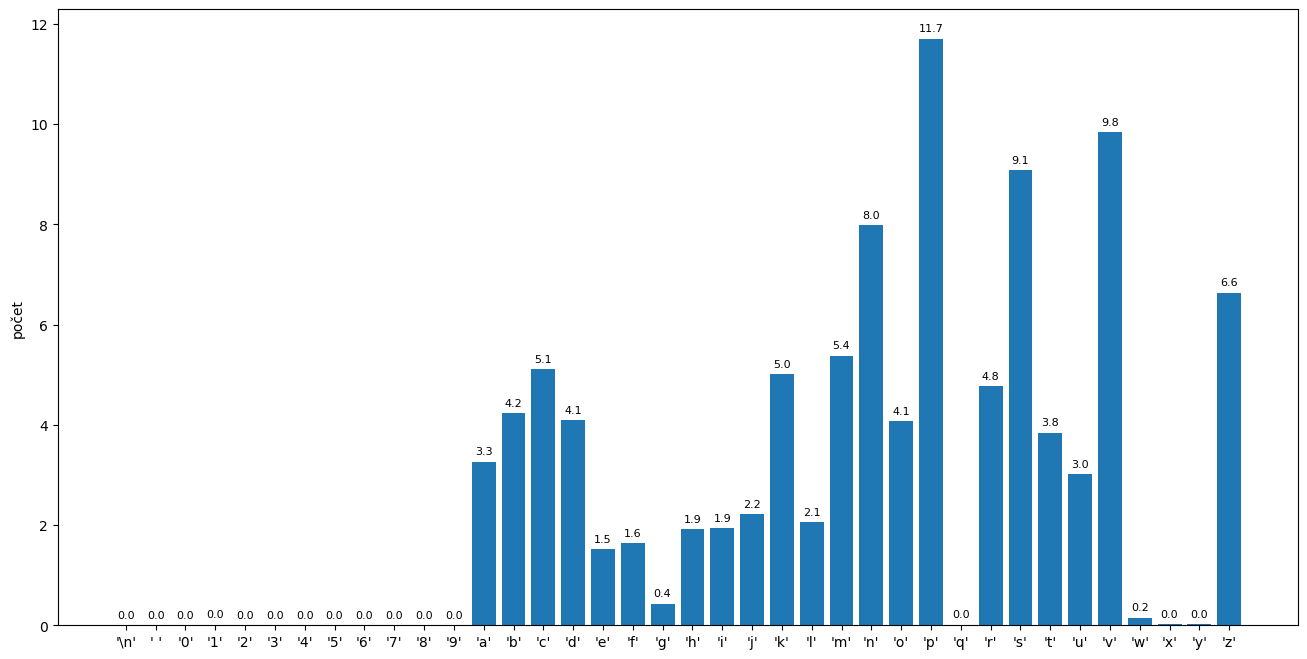

In [7]:
plt.figure(figsize=(16, 8))
rects = plt.bar(range(len(chars)), 100. * p0)
plt.xticks(range(len(chars)), ['{}'.format(repr(c)) for c in chars])
for r in rects:
    x, w, h = r.get_x(), r.get_width(), r.get_height()
    plt.text(x + w / 2., h + 0.1, '{:.1f}'.format(h), ha='center', va='bottom', fontsize=8)
plt.ylabel('počet');
plt.show()

# Sekvenční data a PyTorch

## Embedding

Následující funkce `str2idt` převede řetězec na sekvenci čísel (index tensor) odpovídajících indexům znaků v tabulce. Pokud např. bude celý náš "slovník" `chars = ['a', 'b', 'c']`, pak funkce `str2idt` převede řetězec `'acba'` na `[0, 2, 1, 0]`. Výsledek vrátí jako PyTorch `torch.Tensor`.

In [8]:
def str2idt(string):
    tensor = torch.zeros(len(string)).long()
    for c in range(len(string)):
        tensor[c] = chr2idx[string[c]]
    return tensor

In [9]:
# nas slovnik ma 38 znaku, takze indexy znaku budou jine
x = str2idt('abca')
x

tensor([12, 13, 14, 12])

Další funkce bude dělat opak: převede sekvenci indexů na řetězec.

In [10]:
def idt2str(indices):
    return ''.join([chars[i] for i in indices])

In [11]:
idt2str(x)

'abca'

Sekvenci čísel potřebujeme převést na vektory jednotlivých znaků. Tento proces se v anglické literatuře označuje jako embedding a PyTorch ho implementuje jako vrstvu třídou `Embedding`. Vyjádřením této operace diferencovatelnou vrstvou umožňuje učení vektorů, které tedy nemusejí být fixní. O tom ale až příště.

In [12]:
# velikost slovniku je `len(chars)`
# dimenze znakoveho vektoru bude napr. 30
emb = nn.Embedding(len(chars), 30)

# dopredny pruchod
e = emb(x)
e.shape

torch.Size([4, 30])

In [13]:
e

tensor([[ 0.4557,  1.9995,  0.6302,  0.0720, -1.0245, -0.5744, -0.0923,  0.0560,
         -0.6536,  0.0991,  1.6706,  0.1062,  0.2529,  1.9503,  0.7142,  1.3709,
          0.2447,  0.1714, -2.4037, -1.1285,  0.1038, -0.2374,  1.6430, -0.5453,
         -0.1342, -0.8313,  0.4431, -1.7355, -1.2235,  1.2615],
        [ 1.3846, -0.9406,  0.1050,  1.2202,  0.4589,  1.7300,  0.5752,  0.1435,
          1.1644, -0.2011,  1.7478, -0.5266,  0.2952,  0.1043,  1.0486, -0.2569,
         -1.1252,  1.2360,  0.9916,  0.3481, -0.4290,  2.0518, -0.6132,  0.4050,
          1.1451,  0.3414, -0.4107,  1.5130, -1.1350, -1.3132],
        [-0.3931,  2.1999, -0.4299,  2.6891,  0.6235, -1.0730, -0.1550,  0.1332,
          0.0853, -0.4199, -1.6074,  0.5136, -0.2896,  0.4934,  1.1530,  1.6746,
          0.8868,  0.3384,  0.2117,  1.1768, -0.0212, -1.5892,  0.4666, -0.0596,
         -1.1289, -0.5875, -1.3248, -1.0352,  1.1835,  0.0507],
        [ 0.4557,  1.9995,  0.6302,  0.0720, -1.0245, -0.5744, -0.0923,  0.0560

`Embedding` nedělá nic jiného, než že na výstup pro znak s indexem $i$ vrátí $i$-tý řádek své váhové matice `weight`, která drží vektory slov. Defaultně je tato matice inicializována náhodně. Pokud první písmeno v příkladu bylo 'a', jehož index ve "slovníku" `chars` je 12, první řádek embeddingu `e` bude odpovídat 13. řádku (index 12) matice `emb.weight`.

In [14]:
bool(torch.all(e[0] == emb.weight[12]))

True

## RNN v PyTorch

PyTorch implementuje tři z nejrozšířenějších typů sítí třídami `RNN`, `LSTM` a `GRU`. API je pro všechny stejné: dopředný průchod `forward` očekává "zespodu" nějaký vstup `input` a "zleva" minulý stav `h0`. U `LSTM` je tento stav dvouvektorový. Výstupem je `output`, což je vlastně sekvence skrytých stavů poslední vrstvy rekurentní sítě pro jednotlivé kroky v čase, a nový stav `hn` po provedení celého průchodu. Vše vystihuje následující obrázek.

![](https://i.stack.imgur.com/SjnTl.png)

Zdroj: https://stackoverflow.com/a/48305882/9418551

V nejjednoušším případě máme pouze jednu vrstvu sítě a jeden krok. Potom `output` a `hn` jsou stejné. To znamená, že `output` **neprochází žádnou lineární vrstvou**, jak jsme si to ukazovali na přednáškách, tedy že $y=W^{hy}h$, kde $y$ značí `output`. Transformaci na skóre/pravděpodobnost jednotlivých znaků tedy musíme provést sami. Parametry $W^{hy}$ RNN v PyTorch nezahrnují.

Vstupní tensory $x_i$ na obrázku očekávají PyTorch RNN ve tvaru `(seq, batch, dim)`, kde
- `seq` ... jak jdou znaky ve "věte" za sebou
- `batch` ... počet paralelně zpracovávaných sekvencí, nezávisle na sobě
- `dim` ... příznaky na vstupu

V našem případě jsou vstupy vektory (embeddingy) jednotlivých znaků. Například tedy: `(10, 3, 5)` by znamenalo:
- 3 paralelně zpracovávané
- 10-znakové věty,
- kde každý znak reprezentuje 5dimenzionální vektor

In [15]:
# do site posleme pouze jeden znak; tvar tensoru musi byt (seq, batch, dim), proto musime pouzit reshape
e0 = e[0].reshape(1, 1, -1)
e0.shape

torch.Size([1, 1, 30])

Vytvoříme jednuduchou `torch.nn.RNN`, která na vstupu očekává vektor o rozměru 30 a bude mít skrytý vektor o rozměru 8.

In [16]:
rnn = nn.RNN(30, 8)
rnn

RNN(30, 8)

V PyTorch musíme řešit inicializaci i předávání skrytého stavu v jednotlivých krocích ručně. Umožňuje to tak větší flexibilitu.

In [17]:
# inicializace skryteho stavu a vstupu
# tensory opet musi byt tvaru (seq, batch, dim)
h = torch.rand(1, 1, 8)
h

tensor([[[0.2800, 0.3159, 0.0584, 0.0889, 0.6695, 0.5408, 0.1425, 0.7173]]])

In [18]:
# dopredny pruchod
o, h = rnn(e0, h)
print(e0.shape, h.shape, o.shape, h.shape)

torch.Size([1, 1, 30]) torch.Size([1, 1, 8]) torch.Size([1, 1, 8]) torch.Size([1, 1, 8])


RNN vrátí vždy dvojici `(output, hidden)`, které vysvětluje obrázek výše. V tomto jednoduchém případě, kdy máme pouze jedinou vrstvu, se jedná o tensory se shodnými hodnotami.

In [19]:
bool(torch.all(o == h))

True

Nyní už více samostatně. Zadefinujeme vlastní třídu, která bude řešit jednotlivé kroky sama ve svém dopředném průchodu. Vstupem tedy bude sekvence čísel, výstupem skóre jednotlivých kroků.

In [1645]:
import torch.nn.functional as F

class CharRNN(nn.Module):
    def __init__(self, voc_size, emb_dim, hidden_size, output_size, num_layers):
        super().__init__()

        #################################################################
        # ZDE DOPLNIT
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        
        self.emb = nn.Embedding(voc_size, emb_dim)
        self.rnn = nn.GRU(emb_dim, hidden_size, num_layers)
        self.fc = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.LogSigmoid() 
        
        self.reset_hidden()
        
        #################################################################

    def forward(self, x):
        
        #################################################################
        # ZDE DOPLNIT
        
        embedd = self.emb(x).unsqueeze(1)
        output, h = self.rnn(embedd, self.hidden)
        self.hidden = h
        score = self.fc(output)
        score = self.sigmoid(score)
        #################################################################
        
        return score

    def reset_hidden(self):
        
        #################################################################
        # ZDE DOPLNIT
        # funkce resetuje hidden state na nuly
        
        self.hidden = torch.zeros(self.num_layers, 1, self.hidden_size)
        
        #################################################################

In [1646]:
#################################################################
# ZDE DOPLNIT
voc_size = len(chars)
emb_dim = 500
hidden_dim = 256
output_dim = len(chars)
#################################################################

rnn = CharRNN(voc_size, emb_dim, hidden_dim, output_dim, num_layers=2)
stats = ans.Stats()

In [1752]:
def sample(rnn, init_text='', maxlen=150, mode='multinomial', temperature=0.6):
    """
    generuje text pomoci modelu `rnn`
    
    vstupy:
        rnn ... rekurentni sit odvozena z `nn.Module`, ktera po zavolani vraci dvojici (vyst_skore, skryta_rep)
        init_text ... inicializacni text, na ktery generovani textu navaze
        maxlen ... maximalni delka generovaneho textu
        mode ... zpusob vyberu nasledujiciho znaku, viz komentare v kodu
        temperature ... vyhlazeni multinomialniho rozlozeni, viz komentare v kodu
    """
    # vystupni text bude pole (na konci prevedeme zpet na str)
    out_text = list(init_text)
    
    # pokud nezadan, inicializujeme nahodne, dle rozlozeni prvnich znaku
    if not out_text:
        k = np.random.choice(len(chars), p=p0)
        out_text = [chars[k]]
    
    # vstup projedeme siti, abychom ziskali aktualni hidden stav
    rnn.reset_hidden()
    if len(out_text) > 1:
        x = str2idt(out_text[:-1])
        score = rnn(x)
    # pravdepodobnosti muzeme pocitat softmaxem
    softmax = nn.Softmax(dim=2)

    while True:
        # nasledujici znak je posledni znak prozatimniho vystupu
        x = str2idt(out_text[-1])
        
        # dopredny pruchod
        score = rnn(x)
        # pravdepodobnosti znaku
        prob = softmax(score).flatten()
        # vyberem index `k` nasleduciho znaku
        if mode == 'multinomial':
            # nasledujici znak bude vybran dle ad hoc multinomialniho rozlozeni
            # parametr `temperature` ... vyssi hodnota znamena nahodnejsi vysledky
            # viz https://github.com/karpathy/char-rnn#sampling
            k = torch.multinomial(score.flatten().div(temperature).exp(), 1)[0]
        elif mode == 'argmax':
            #################################################################
            # ZDE DOPLNIT
            
            # nasledujici znak bude ten, jehoz pravdepodobnost vysla maximalni
            k = int((prob == torch.max(prob)).nonzero(as_tuple=True)[0])
            
            #################################################################
        elif mode == 'proportional':
            #################################################################
            # ZDE DOPLNIT
            
            # nasl. znak se vybere nahodne, ale s pravdepodobnosti proporcionalni k vystupu softmaxu
            # napr. pokud znak 'x' ma dle softmaxu 84 %, bude s pravdepodobnosti 84 % vybran jako vstup do dalsi iterace
            
            k = np.random.choice(len(chars), p=prob.detach().numpy())
            
            #################################################################
        
        #################################################################
        # ZDE DOPLNIT
        
        # zastavit, pokud end-token
        if chars[k] == '\n':
            break
        
        # pridat znak na vystup
        out_text += chars[k]
        
        # zastavit, pokud text je moc dlouhy
        if len(out_text) > maxlen:
            break
        
        #################################################################
    
    return ''.join(out_text)

Vytvoříme si také funkci pro samplování z naší sítě. Funkce přijme model `rnn` a nějaký inicializační text `init_text` a vygeneruje text - vrací tedy string.

In [1754]:
print(sample(rnn, init_text='prezident', mode='proportional'))

prezidenti na predikl zavnakotne odred prevneho bezletikanou ktebra bvil oominy


# Trénování

V každé iteraci pomocí funkce `char_tensor` vytvoříme trénovací data `(inpt, targ)`, což budou číselné indexy znaků tak, jak je definuje tabulka `chr2idx`. Budeme trénovat generování znaků, tzn. že požadovaným výstupem (label, target) `targ[i]` pro vstup `inpt[i]` je vždy následující znak `inpt[i+1]`. Vektor `targ` je tedy v tomto případě stejného rozměru jako `inpt`. Nezapomeňte na poslední znak, který má jako target `\n` značící konec sekvence.

Vyzkoušejte si na příkladu:

In [1701]:
line = random.choice(lines)
print(line)

ctvrtnickovi ve filmu andel pane 2 anicka prekonala tatu


In [1702]:
#################################################################
# ZDE DOPLNIT

inpt = str2idt(line)
targ = str2idt(line[1:] + '\n')
#################################################################

In [1703]:
print('vstup:   {} ... {}'.format(idt2str(inpt[:10]), idt2str(inpt[-10:])))
print('target:  {} ... {}'.format(idt2str(targ[:10]), idt2str(targ[-10:])))

vstup:   ctvrtnicko ... onala tatu
target:  tvrtnickov ... nala tatu



In [1704]:
crit = nn.CrossEntropyLoss()

In [1705]:
#################################################################
# ZDE DOPLNIT

optimizer = torch.optim.Adam(rnn.parameters())
#optimizer = torch.optim.SGD(rnn.parameters(), lr=0.0001, momentum=0.9)
optimizer
#################################################################

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
)

In [1706]:
stats = ans.Stats()

In [1707]:
example = sample(rnn, mode='argmax')
max_per_epoch = 1000
rnn.train()

scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[1, 3, 6, 8, 10, 12, 15, 18, 21], gamma=0.01)
for epoch in range(80):
    # data budou nahodne prehazena
    train_lines = random.sample(lines, max_per_epoch)
    # progressbar
    pb = tqdm.tqdm_notebook(train_lines, desc='ep {:03d}'.format(len(stats)))
    
    stats.new_epoch()
    
    for it, line in enumerate(pb):
        rnn.reset_hidden()
        #################################################################
        # ZDE DOPLNIT
        inpt = str2idt(line)
        targ = str2idt(line[1:] + '\n')
        softmax = nn.Softmax(dim=2)
        scores = rnn(inpt).squeeze(1)
        loss = crit(scores, targ)
        #################################################################
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if it % 100 == 0:
            rnn.eval()
            example = sample(rnn)
            rnn.train()
        
        stats.append_batch_stats('train', loss=float(loss))
        pb.set_postfix(loss='{:.3f}'.format(stats.ravg('train', 'loss')), ex=example[:40])
    scheduler.step()
    
# pripadne ulozit model
# torch.save(rnn.state_dict(), f'lstm-{epoch:02d}.pth')

<ipython-input-1707-d9d025a34a81>:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  pb = tqdm.tqdm_notebook(train_lines, desc='ep {:03d}'.format(len(stats)))


ep 000:   0%|          | 0/1000 [00:00<?, ?it/s]

ep 001:   0%|          | 0/1000 [00:00<?, ?it/s]

ep 002:   0%|          | 0/1000 [00:00<?, ?it/s]

ep 003:   0%|          | 0/1000 [00:00<?, ?it/s]

ep 004:   0%|          | 0/1000 [00:00<?, ?it/s]

ep 005:   0%|          | 0/1000 [00:00<?, ?it/s]

ep 006:   0%|          | 0/1000 [00:00<?, ?it/s]

ep 007:   0%|          | 0/1000 [00:00<?, ?it/s]

ep 008:   0%|          | 0/1000 [00:00<?, ?it/s]

ep 009:   0%|          | 0/1000 [00:00<?, ?it/s]

ep 010:   0%|          | 0/1000 [00:00<?, ?it/s]

ep 011:   0%|          | 0/1000 [00:00<?, ?it/s]

ep 012:   0%|          | 0/1000 [00:00<?, ?it/s]

ep 013:   0%|          | 0/1000 [00:00<?, ?it/s]

ep 014:   0%|          | 0/1000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [1708]:
torch.save(rnn.state_dict(), f'lstm-{epoch:06d}.pth')
stats.plot_by_batch(block_len=10, right_metric=None)

In [1713]:
rnn.eval()
for i in range(5):
    print(sample(rnn, init_text='prezi', mode='multinomial'))
    print("===================")

prezit vystavnika nese o veruje hodel poline na poradni si v nejmeni
prezit za na domali rozmerista sorada se jedni oblavi zadalo kamari ma nameni nepat
prezila vyda nestra bele boje na konci je ostrero po mozi
prezidente trotbvy podvodni kralici ministorel gelepla se sestrati zabil ze vyzakan milaris krade
prezivat doslobu obezivu plozil prezide po zemovala za ma proveli na jedem
